Notes:

1. This code is for xxz's POC model attempt
2. This code will not mimic how search engine works. Instead, this code just to give a post/article a score for ranking. The main table I used is assumed as the COPA search engine results rather than the database
3. The attributes and their scores are decided by xxz's personal intuition rather than rigorous research
4. The final score will measure
    - Authors' quality (likes per post)
    - Sources' quality (wiki-1, blog-2, magazine-3)
    - Contents' quality (subjectivity, length, number of comments)
5. These scores are weighted equally in the final score. Please feel free to change. 

In [13]:
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as ps
from scipy import stats

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

# Combine All Files

In [2]:
#upload the csv file
wiki_df = pd.read_csv("wiki_formal_total_clean.csv")
blog_df = pd.read_csv("blog_clean.csv")
maga_df = pd.read_csv("maga_clean.csv")

In [3]:
#select several common or useful columns
blog_df=blog_df[['Title','Author','Body','Like','Comment']]
wiki_df=wiki_df[['Title','Author','Content','Like']]
maga_df=maga_df[['Article','Author','Content']]

In [4]:
#rename the columns
blog_df.rename(columns = {'Body':'Content'}, inplace = True) 
maga_df.rename(columns = {'Article':'Title'}, inplace = True) 
#add a new column to show the source
blog_df['Source']='blog'
wiki_df['Source']='wiki'
maga_df['Source']='maga'
df_total=blog_df.append(wiki_df, ignore_index=True)
df_total=df_total.append(maga_df, ignore_index=True)

C:\Users\xingxuan_dell\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
#change all string data to lower case
df_total.iloc[:,0]=df_total.iloc[:,0].apply(lambda x:x.lower())
df_total.iloc[:,2]=df_total.iloc[:,2].apply(lambda x:x.lower())
df_total.iloc[:,5]=df_total.iloc[:,5].apply(lambda x:x.lower())


# Authors' Quality

In [9]:
#use sql to get 'how many articles an author wrote', and 'how many likes an author received'
q1 = """SELECT Author, count(Author) as AuthorPost,sum(Like) as AuthorLike  FROM df_total GROUP BY Author ORDER BY count(Author) desc"""
Author_tb=ps.sqldf(q1, locals())

#calculate the likes/#posts, this can be understanded as likes per post (may be represented as authors' post quality)
Author_tb['AuthorLikeProp']=Author_tb['AuthorLike']/Author_tb['AuthorPost']
Author_tb=Author_tb.sort_values('AuthorLikeProp', ascending=False)
Author_tb

,Author,AuthorPost,AuthorLike,AuthorLikeProp
20,michael samp,1,1.0,1.000000
8,john ylinen,4,3.0,0.750000
2,rick beach,70,18.0,0.257143
9,steve lucas,4,1.0,0.250000
7,peter storer,29,3.0,0.103448
1,roger whittier,123,11.0,0.089431
0,eharrison,138,2.0,0.014493
18,mark craig,1,0.0,0.000000
25,stuart simek,1,0.0,0.000000
24,stephen upton,1,0.0,0.000000


In [10]:
#add likes per post to the main table
df_total=pd.merge(Author_tb, df_total, left_on='Author', right_on='Author')

# Sources' Quality

In [11]:
#Ranking the source, blog is the most important source so have 3
raw_data = {
        'Source': ['wiki','blog','maga'],
        'SourceScore': ['1', '3', '2']}
Source_tb = pd.DataFrame(raw_data, columns = ['Source', 'SourceScore'])
#add source score to the main table
df_total=pd.merge(Source_tb, df_total, left_on='Source', right_on='Source')


# Contents' Quality

## Sentiment Analysis

In [14]:
# use TextBlob to do the sentiment analysis on content
# here I only use the subjectivity score to analyze whether the content is objective or subjective
# the assumption here is that objective contents' quality will be better
df_total['ContentSubjective']=df_total.Content.apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [12]:
# round the subjectivity score
df_total['ContentSubjective']=df_total['ContentSubjective'].apply(lambda x:round(x,1))

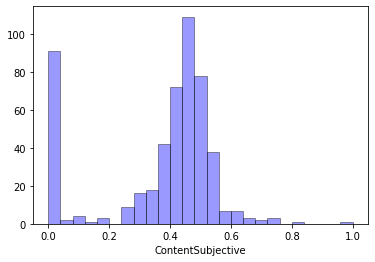

In [15]:
# display the subjectivity score [0 objective ----1 subjective]
sns.distplot(df_total['ContentSubjective'], hist=True, kde=False, color = 'blue',
             hist_kws={'edgecolor':'black'})

## Content Length

In [16]:
#calculate the length of content
df_total['ContentLen']=df_total.Content.apply(lambda x:len(x))

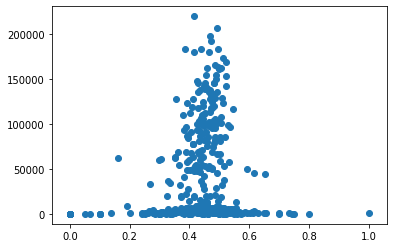

In [17]:
#display the relationship between content subjective and length
plt.scatter(df_total.ContentSubjective, df_total.ContentLen)

In [17]:
# combine to the main table
df_total=df_total[['SourceScore','AuthorLikeProp','Comment','Content','Like','Title','ContentSubjective','ContentLen']]

## Num of Comments per post

use the data directly

# Form Scoring Model

In [31]:
df_total

,Source,SourceScore,Author,AuthorPost,AuthorLike,AuthorLikeProp,Comment,Content,Like,Title,ContentSubjective,ContentLen
0,wiki,1,michael samp,1,1.0,1.000000,NaN,"i am based in colorado springs, co and often s...",1.0,oil door support for summer time cooling,0.460000,695
1,wiki,1,john ylinen,4,3.0,0.750000,NaN,"""can i fix my audio volume problem?actually, t...",0.0,low aux audio volume problem,0.351296,5520
2,wiki,1,john ylinen,4,3.0,0.750000,NaN,activating garmin 396contentsstep 1step 2step ...,0.0,activating garmin 396,0.531481,952
3,wiki,1,john ylinen,4,3.0,0.750000,NaN,"a good reason to do your own oil change, or at...",3.0,oil change,0.443013,13756
4,wiki,1,john ylinen,4,3.0,0.750000,NaN,contentsmicrosoft flight simulator x (fsx) and...,0.0,microsoft flight simulator,0.461732,5976
5,wiki,1,steve lucas,4,1.0,0.250000,NaN,"the general aviation modifications, inc. (gami...",0.0,gami lean test,0.369927,3546
6,wiki,1,steve lucas,4,1.0,0.250000,NaN,"""the standard pre-flight engine run-up check i...",1.0,in-flight lop magneto check,0.477752,6511
7,wiki,1,steve lucas,4,1.0,0.250000,NaN,lean of peakcan you run your engine lean of pe...,0.0,lean of peak engine operation,0.373690,1553
8,wiki,1,steve lucas,4,1.0,0.250000,NaN,use the following chart to better describe iss...,0.0,magnetos and spark plug location,0.300000,100
9,wiki,1,peter storer,29,3.0,0.103448,NaN,low aux audio volume problem,0.0,entertainment accessories,0.300000,28


In [32]:
#use the percentile to assign the rank
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html
#'mean'is used when two posts have the same number
df_total['AuthorRank']=df_total.AuthorLikeProp.apply(lambda x: stats.percentileofscore(df_total.AuthorLikeProp,x, kind='mean'))

In [34]:
df_total['LikeRank']=df_total.Like.apply(lambda x: stats.percentileofscore(df_total.Like,x, kind='mean'))

In [35]:
df_total['CommentRank']=df_total.Comment.apply(lambda x: stats.percentileofscore(df_total.Comment,x, kind='mean'))

In [36]:
# Based on the assumption that the objective content is better than subjective content, we use reverse the rank
df_total['ObjectiveRank']=100-(df_total.ContentSubjective.apply(lambda x: stats.percentileofscore(df_total.ContentSubjective,x, kind='mean')))

In [37]:
df_total['CountRank']=df_total.ContentLen.apply(lambda x: stats.percentileofscore(df_total.ContentLen,x, kind='mean'))

In [38]:
# rescale the source rank to match with other ranks by multiplying by 10
df_total['SourceRank']=df_total.SourceScore.apply(lambda x: int(x)*10)

In [39]:
# conduct a score table
df_score=df_total[['AuthorRank','LikeRank','CommentRank','ObjectiveRank','CountRank','SourceRank']]

In [40]:
# fill missing data with median fo each column
df_score=df_score.apply(lambda x: x.fillna(x.median()),axis=0)

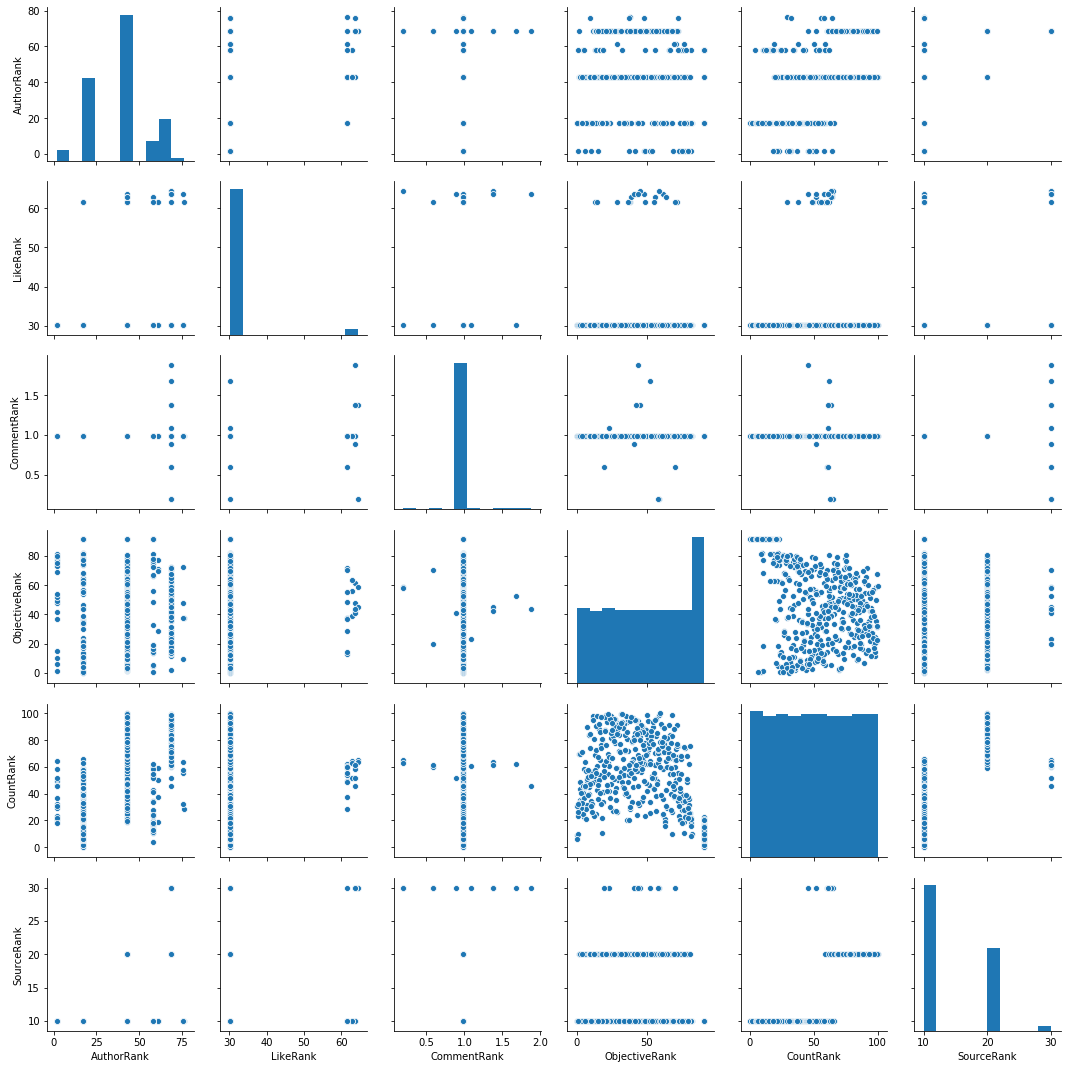

In [41]:
# display the score
sns.pairplot(df_score)

In [42]:
# get an average score
df_total['Rank']=df_score.sum(axis = 1, skipna = True).apply(lambda x:x/5)

In [43]:
df_total

,Source,SourceScore,Author,AuthorPost,AuthorLike,AuthorLikeProp,Comment,Content,Like,Title,ContentSubjective,ContentLen,AuthorRank,LikeRank,CommentRank,ObjectiveRank,CountRank,SourceRank,Rank
0,wiki,1,michael samp,1,1.0,1.000000,NaN,"i am based in colorado springs, co and often s...",1.0,oil door support for summer time cooling,0.460000,695,76.232742,61.538462,NaN,37.771203,28.698225,10,43.045365
1,wiki,1,john ylinen,4,3.0,0.750000,NaN,"""can i fix my audio volume problem?actually, t...",0.0,low aux audio volume problem,0.351296,5520,75.739645,30.276134,NaN,72.090730,55.719921,10,48.962525
2,wiki,1,john ylinen,4,3.0,0.750000,NaN,activating garmin 396contentsstep 1step 2step ...,0.0,activating garmin 396,0.531481,952,75.739645,30.276134,NaN,9.566075,32.248521,10,31.763314
3,wiki,1,john ylinen,4,3.0,0.750000,NaN,"a good reason to do your own oil change, or at...",3.0,oil change,0.443013,13756,75.739645,63.609467,NaN,48.027613,64.003945,10,52.473373
4,wiki,1,john ylinen,4,3.0,0.750000,NaN,contentsmicrosoft flight simulator x (fsx) and...,0.0,microsoft flight simulator,0.461732,5976,75.739645,30.276134,NaN,37.179487,57.692308,10,42.374753
5,wiki,1,steve lucas,4,1.0,0.250000,NaN,"the general aviation modifications, inc. (gami...",0.0,gami lean test,0.369927,3546,61.143984,30.276134,NaN,70.710059,50.000000,10,44.623274
6,wiki,1,steve lucas,4,1.0,0.250000,NaN,"""the standard pre-flight engine run-up check i...",1.0,in-flight lop magneto check,0.477752,6511,61.143984,61.538462,NaN,28.895464,59.072978,10,44.327416
7,wiki,1,steve lucas,4,1.0,0.250000,NaN,lean of peakcan you run your engine lean of pe...,0.0,lean of peak engine operation,0.373690,1553,61.143984,30.276134,NaN,69.723866,37.376726,10,41.901381
8,wiki,1,steve lucas,4,1.0,0.250000,NaN,use the following chart to better describe iss...,0.0,magnetos and spark plug location,0.300000,100,61.143984,30.276134,NaN,76.824458,19.033531,10,39.652860
9,wiki,1,peter storer,29,3.0,0.103448,NaN,low aux audio volume problem,0.0,entertainment accessories,0.300000,28,57.889546,30.276134,NaN,76.824458,10.453649,10,37.285996


In [44]:
# sort the table based on the score
df_total.sort_values(by=['Rank'],ascending = False)

,Source,SourceScore,Author,AuthorPost,AuthorLike,AuthorLikeProp,Comment,Content,Like,Title,ContentSubjective,ContentLen,AuthorRank,LikeRank,CommentRank,ObjectiveRank,CountRank,SourceRank,Rank
319,blog,3,rick beach,70,18.0,0.257143,2.0,(this article appears as the safety column in ...,1.0,"""reach the unreachable"" safety column in copa ...",0.372226,6960,68.441815,61.538462,0.591716,70.315582,60.256410,30,58.228797
317,blog,3,rick beach,70,18.0,0.257143,0.0,"by rick beach, copa safety chair this unusual ...",4.0,"caps deployment anomaly at colorado springs, c...",0.416405,18574,68.441815,64.299803,0.197239,58.678501,64.990138,30,57.321499
386,maga,2,rick beach,70,18.0,0.257143,NaN,november december 201244 cirrus pilotso he had...,NaN,safety feature,0.384995,183644,68.441815,NaN,NaN,67.751479,99.112426,20,57.313609
384,maga,2,rick beach,70,18.0,0.257143,NaN,january february 201744cirrus pilotfinalflairs...,NaN,safety feature,0.356620,127300,68.441815,NaN,NaN,71.696252,91.617357,20,56.603550
374,maga,2,rick beach,70,18.0,0.257143,NaN,may june 201644cirrus pilotmaintain positional...,NaN,safety feature,0.416063,179824,68.441815,NaN,NaN,58.875740,98.520710,20,55.420118
329,maga,2,rick beach,70,18.0,0.257143,NaN,january february 201940 copa pilotthis unusual...,NaN,safety talk,0.391974,122927,68.441815,NaN,NaN,65.581854,91.025641,20,55.262327
322,blog,3,rick beach,70,18.0,0.257143,5.0,"foryears,safetyadvocateshavepreached that pilo...",4.0,copa/cirrus aircraft examine loss of control a...,0.447903,13074,68.441815,64.299803,1.380671,44.871795,63.609467,30,54.520710
382,maga,2,rick beach,70,18.0,0.257143,NaN,september october 201844 copa pilotmy preferen...,NaN,safety feature,0.424754,148157,68.441815,NaN,NaN,56.311637,95.956607,20,54.394477
332,maga,2,rick beach,70,18.0,0.257143,NaN,july august 201544cirrus pilotberg lakes yakat...,NaN,safety feature,0.408833,119034,68.441815,NaN,NaN,61.045365,90.236686,20,54.197239
369,maga,2,rick beach,70,18.0,0.257143,NaN,may 201940 copa piloteffective recurrent train...,NaN,safety talk,0.389757,96465,68.441815,NaN,NaN,66.370809,83.727811,20,53.960552
